### Attention Maps Visualization

In [19]:
import os
import json
import argparse
from time import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli
import torch.nn as nn
from models.transformer import get_model
from datasets import SudokuDataset_Mask,SudokuDataset_Solver
from sudoku_solver.board import check_input_board,check_consistency_board

def init_parser():
    parser = argparse.ArgumentParser(description='Solver-NN and Mask-Predictor Module for NASR')
    # General args
    parser.add_argument('--gpu-id', default=0, type=int)
    parser.add_argument('-j', '--workers', default=4, type=int,
                        help='number of data loading workers (default: 4)')
    parser.add_argument('--print-freq', default=10, type=int,
                        help='log frequency (by iteration)')
    parser.add_argument('--batch-size', default=100, type=int,
                        help='Batch size')
    parser.add_argument('--data', type=str, default='big_kaggle',
                        help='dataset name between [big_kaggle, minimal_17, multiple_sol, satnet]')
    parser.add_argument('--noise-setting', default='xxx/yyy.json', type=str,
                        help='Json file of noise setting (dict)')
    parser.add_argument('--module', type=str, default='mask',
                        help='module name between mask or solvernn')
    # Model args
    parser.add_argument('--pos-weights', default=None, type=float,
                        help='ratio neg/pos examples')
    parser.add_argument('--block-len', default=81, type=int,
                        help='board size')
    return parser


def validate(val_loader, model, criterion, args):
    model.eval()
    loss_val = 0
    n = 0
    preds = []
    labels = []
    inputs = []
    attentions = []
    time_begin = time()
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images = images.to(args.gpu_id)
            target = target.to(args.gpu_id)

            pred, attention_list = model(images, return_attention=True)
            loss = criterion(pred, target)
            
            preds.append(pred)
            labels.append(target)
            inputs.append(images)
            attentions.append(attention_list)
            n += images.size(0)
            loss_val += float(loss.item() * images.size(0))

            if args.print_freq >= 0 and i % args.print_freq == 0:
                avg_loss = (loss_val / n)
                print(f'[Test][{i}/{len(val_loader)}] \t AvgLoss: {avg_loss:.4f}')

    avg_loss = (loss_val / n)
    total_mins = (time() - time_begin) / 60
    print(f'AvgLoss {avg_loss:.4f} \t \t Time: {total_mins:.2f}')

    return attentions

In [20]:
import shlex

parser = init_parser()

# visualize attention of neural solver
# puzzles0_kaggle puzzles2_17_clue puzzles7_serg_benchmark satnet
arg_string = '--module solvernn --data satnet'

# visualize attention of mask network
# arg_string = '--module mask --data big_kaggle'
args = parser.parse_args(shlex.split(arg_string))

In [21]:
ckpt_path = f'../outputs/{args.module}/{args.data}/checkpoint_best.pth'
# ----------------------------------
if os.path.isfile(args.noise_setting):
    with open(args.noise_setting) as f:
        noise_setting = json.load(f)
else:
    noise_setting = {"noise_type": "awgn", "snr": -0.5}
noise_setting = str(noise_setting).replace(' ', '').replace("'", "")
# ----------------------------------

assert args.module in ['mask', 'solvernn'], 'error module name, choose between solvernn and mask'
if args.module == 'mask':
    test_dataset = SudokuDataset_Mask(args.data,'-test')
elif args.module == 'solvernn':
    test_dataset = SudokuDataset_Solver(args.data,'-test')


In [22]:
test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers)

# Model
num_classes = -1
in_chans = -1
if args.module == 'solvernn':
    in_chans = 10
    num_classes = 9
else:
    assert args.module == 'mask'
    in_chans = 9
    num_classes = 1


model = get_model(block_len=args.block_len, in_chans = in_chans, num_classes = num_classes)
model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))
model.to(args.gpu_id)

# Loss
if args.pos_weights is not None:
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(args.pos_weights))
else:
    criterion = nn.BCEWithLogitsLoss()


In [23]:
args

Namespace(gpu_id=0, workers=4, print_freq=10, batch_size=100, data='satnet', noise_setting='xxx/yyy.json', module='solvernn', pos_weights=None, block_len=81)

In [24]:
# Main loop

print("Beginning testing")
attentions = validate(test_loader, model, criterion, args)

Beginning testing
[Test][0/5] 	 AvgLoss: 0.0199
AvgLoss 0.0204 	 	 Time: 0.01


In [25]:
type(attentions)

list

In [26]:
len(attentions)

5

In [27]:
len(attentions[0])

4

In [28]:
attentions[0][0].shape

torch.Size([100, 3, 81, 81])

In [29]:
att = [[] for l in attentions[0]]
for a in attentions:
    for a_l, a_ in zip(att, a):
        # average over batch dimension
        a_l.append(a_.mean(dim=0))

In [30]:
len(att)

4

In [31]:
att[0][0].shape

torch.Size([3, 81, 81])

In [32]:
means = []
for a in att:
    # average over list of batches
    a_ = (np.mean(np.asarray([a__.numpy() for a__ in a]), axis=0))
    # average over heads
    # model.blocks[0].attn.num_heads
    a_ = np.mean(a_, axis=0)
    means.append(a_)

In [33]:
attn = np.mean(means, axis=0)

In [34]:
import matplotlib.pyplot as plt

In [35]:
def visualize(attn, file_prefix='attn'):
    if not os.path.isdir('../data/figures'):
        os.mkdir('../data/figures')
    for i in range(len(attn)):
        fig = plt.figure(figsize=(5, 5), dpi=100)
        figure = fig.add_subplot(111)
        
        major_ticks = np.arange(-0.5, 9.5, step=3)
        minor_ticks = np.arange(-0.5, 9.5, step=1)
        figure.set_xticks(major_ticks)
        figure.set_xticks(minor_ticks, minor=True)
        figure.set_yticks(major_ticks)
        figure.set_yticks(minor_ticks, minor=True)
        figure.grid(True, which='both', color='w', linestyle='-')
        plt.grid()
        figure.grid(True, which='major', alpha=1, linewidth=1)
        figure.grid(True, which='minor', alpha=0.5, linewidth=0.5)
        figure.set_xticklabels([])
        figure.set_yticklabels([])
        for tick in figure.xaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)
        for tick in figure.xaxis.get_minor_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)
        for tick in figure.yaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)
        for tick in figure.yaxis.get_minor_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)
        #plt.xlim(0,9)
        #plt.ylim(9, 0)
        att_to_show = attn[i].reshape(9,9)
        plt.imshow(att_to_show)
        plt.savefig('../data/figures/{}_{}.png'.format(file_prefix, i))
        plt.show()

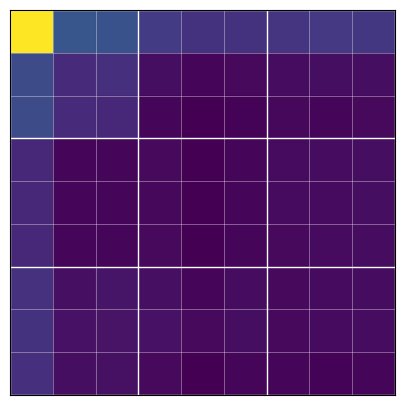

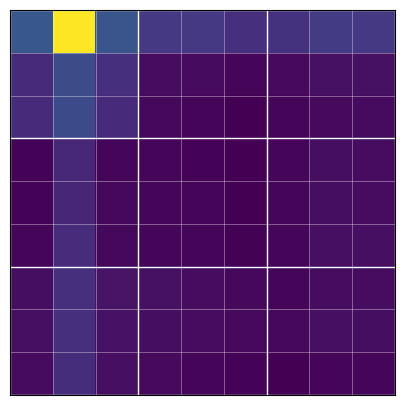

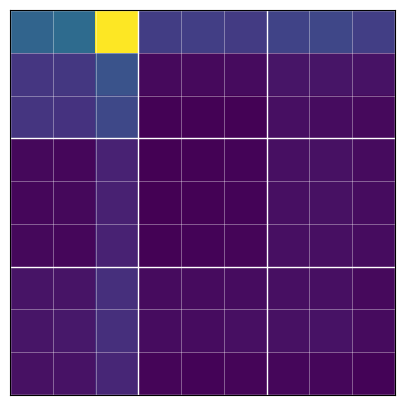

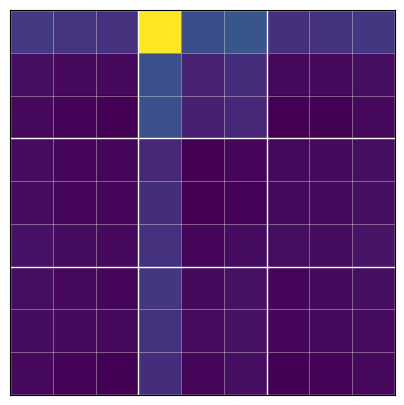

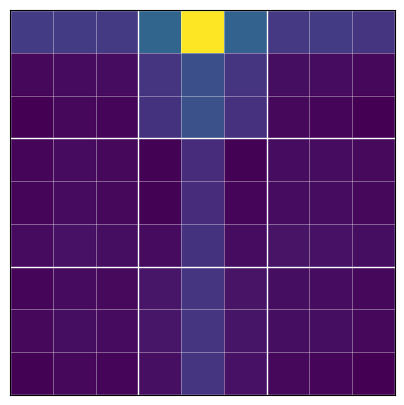

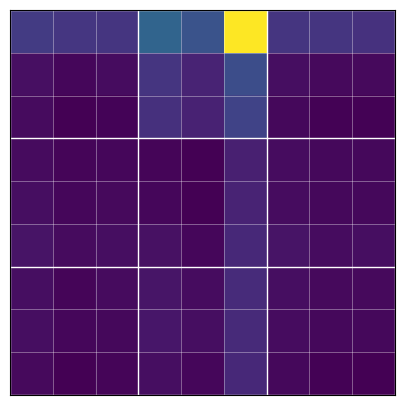

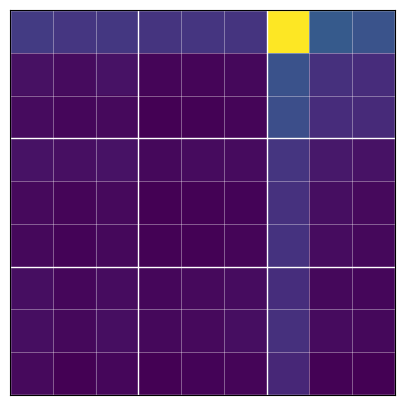

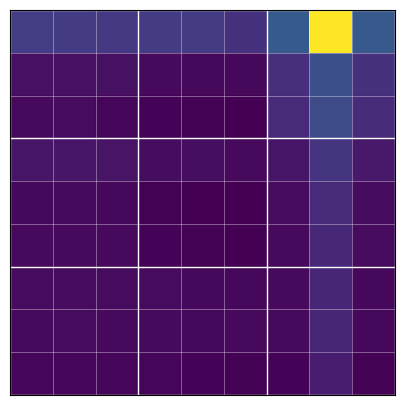

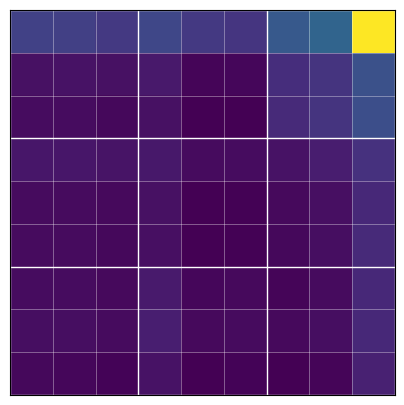

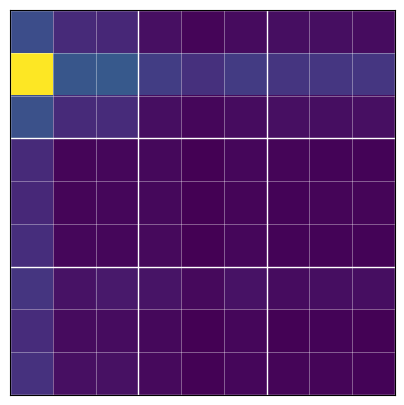

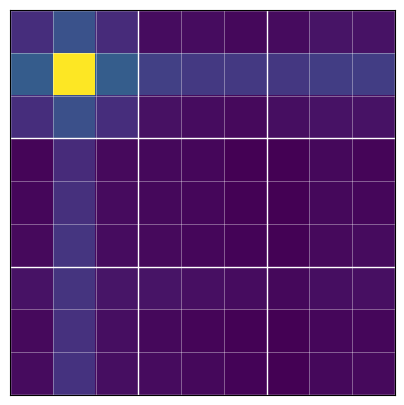

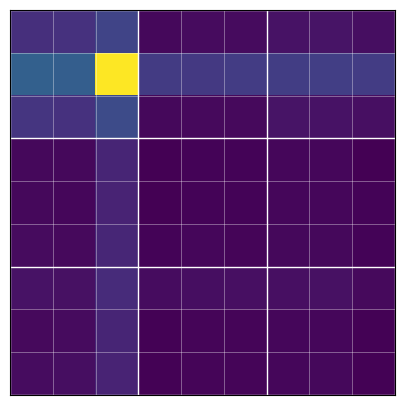

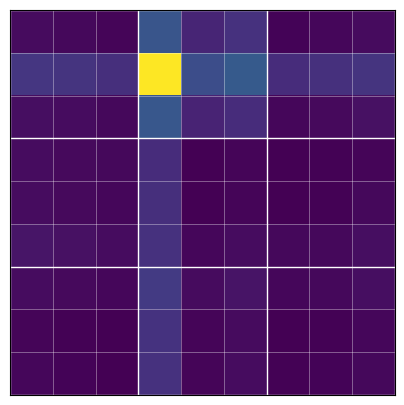

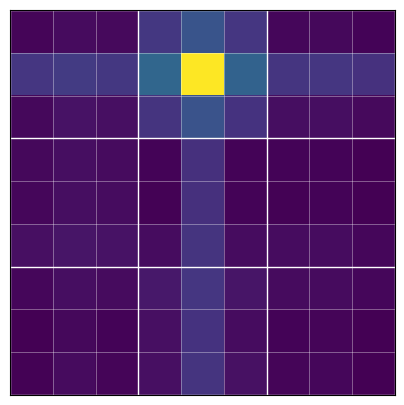

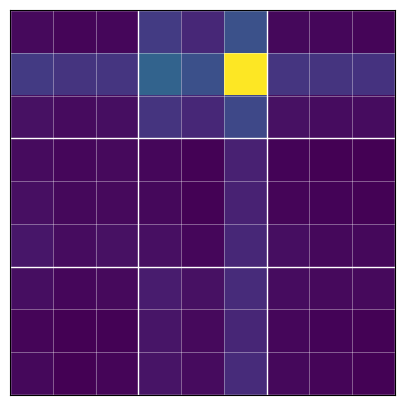

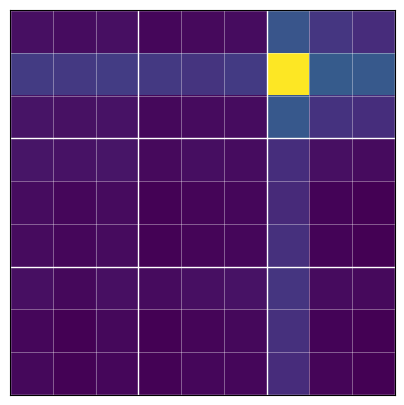

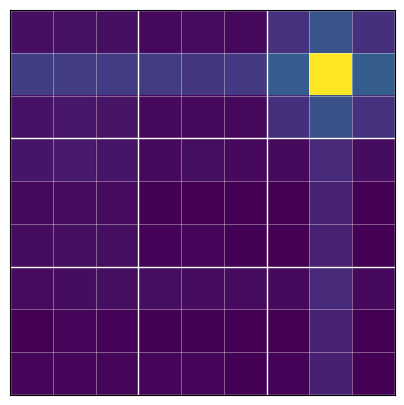

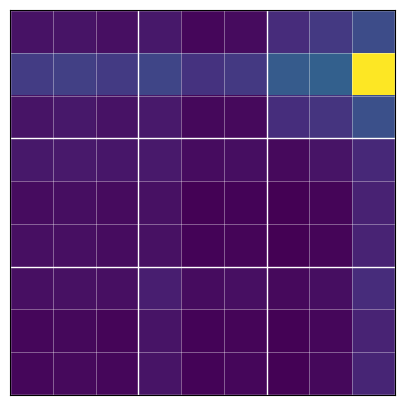

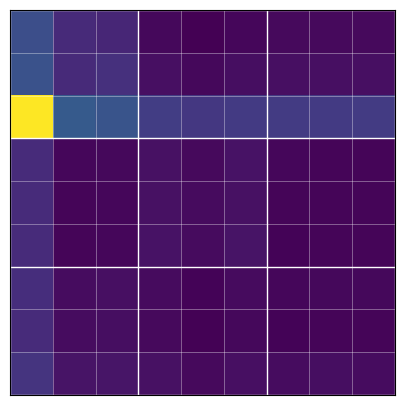

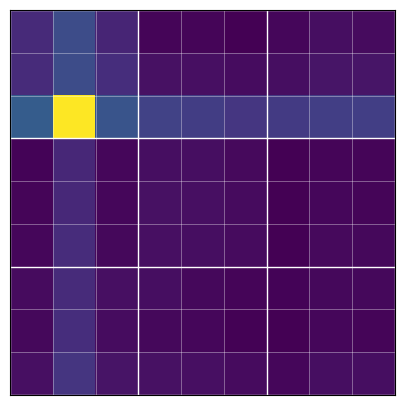

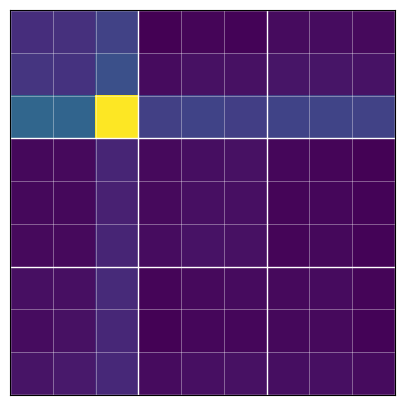

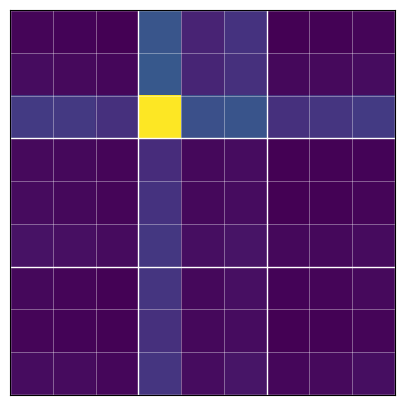

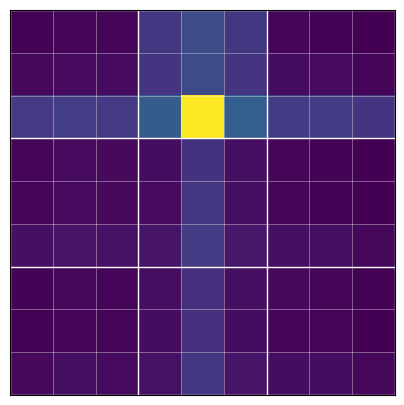

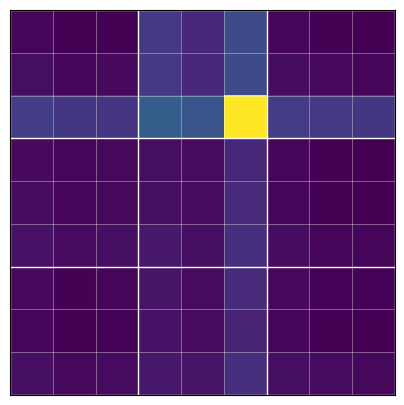

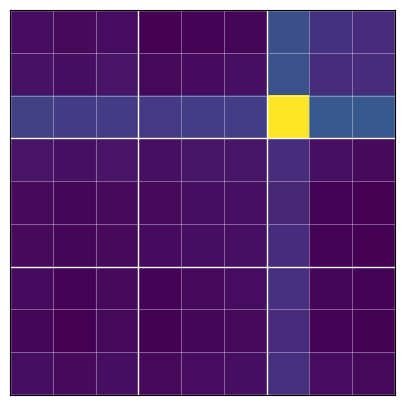

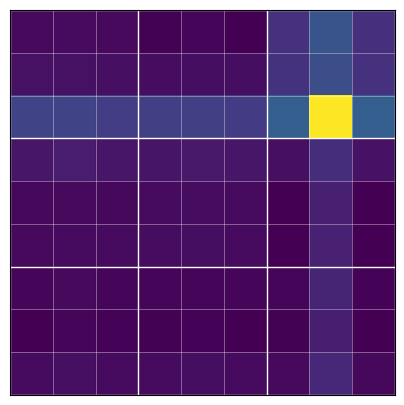

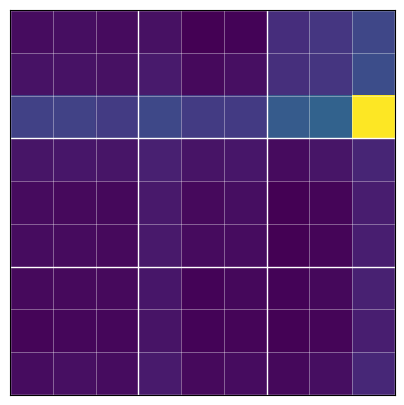

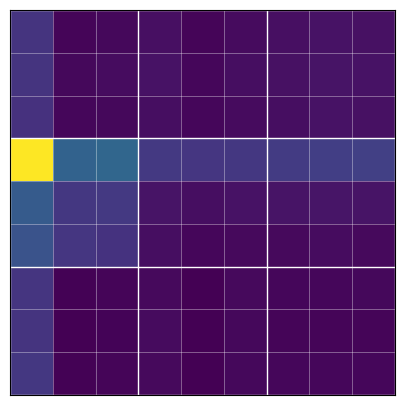

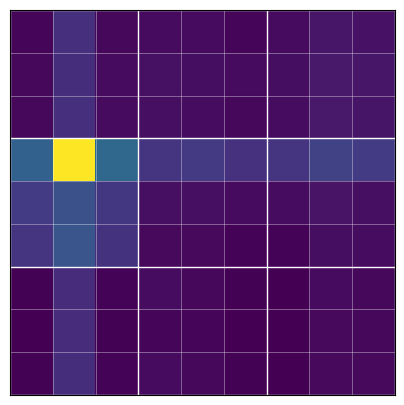

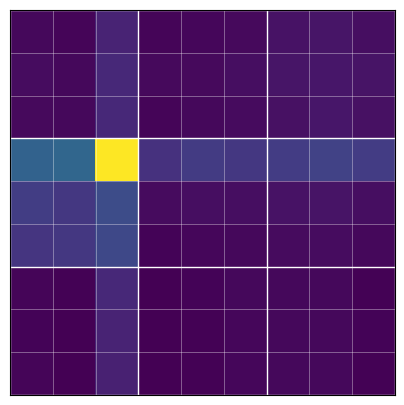

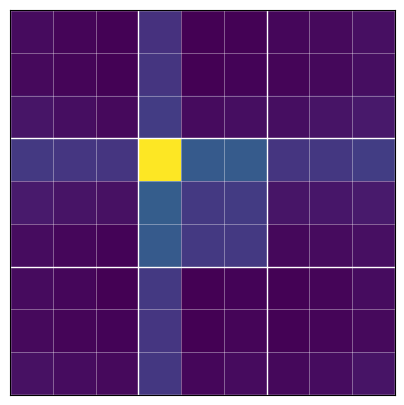

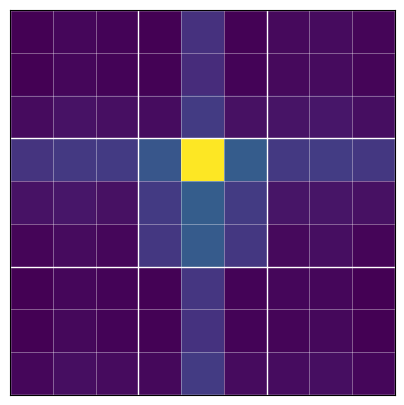

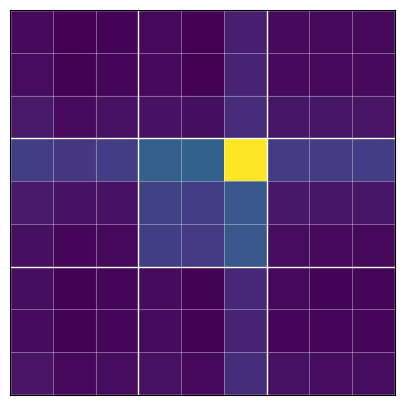

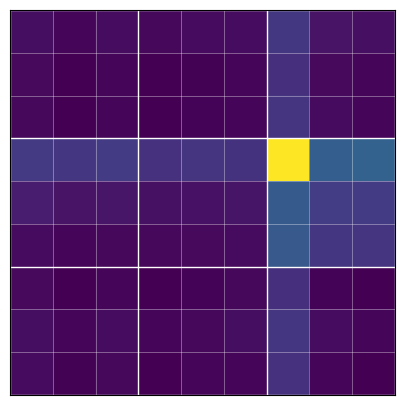

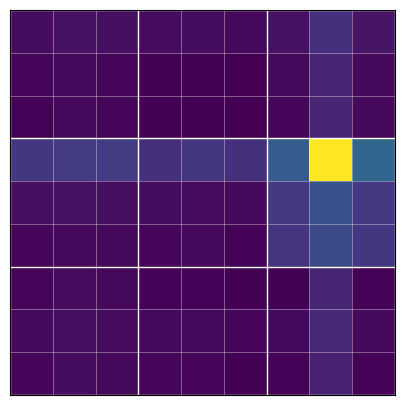

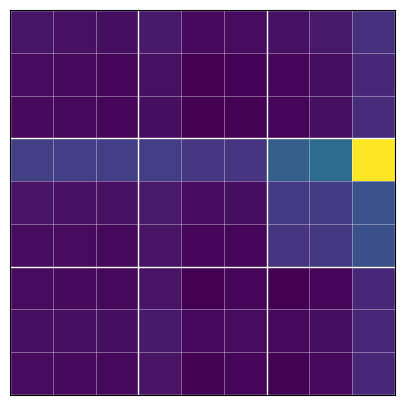

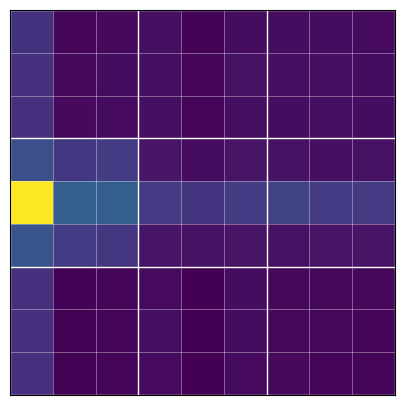

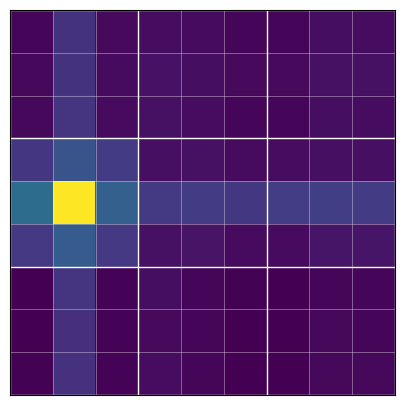

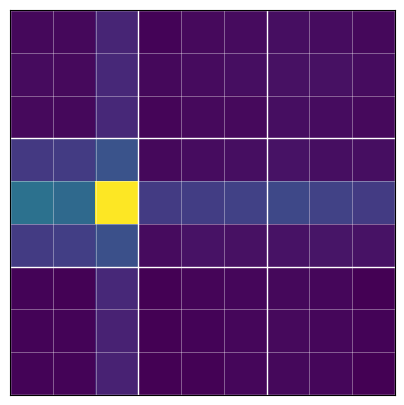

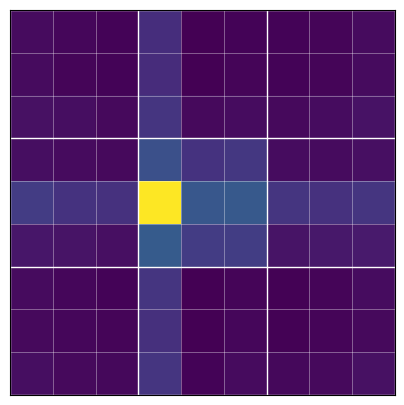

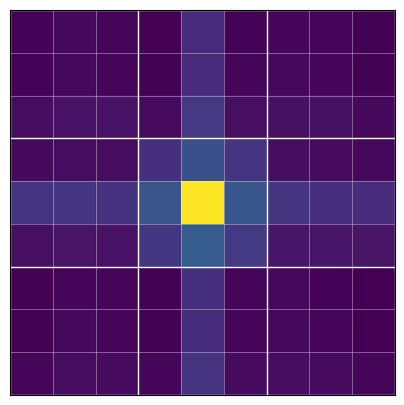

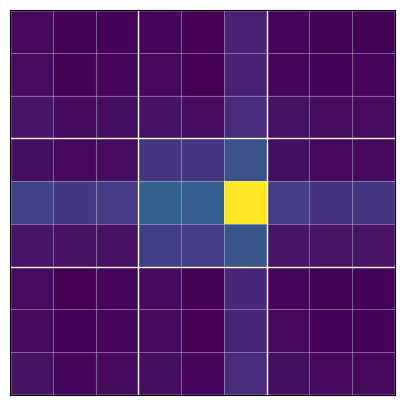

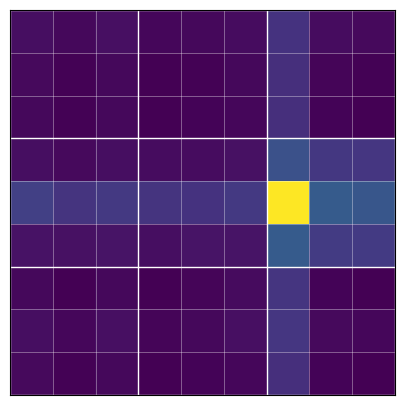

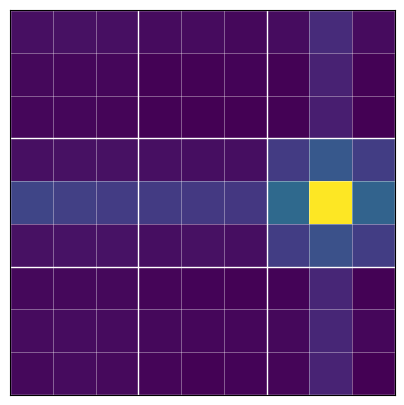

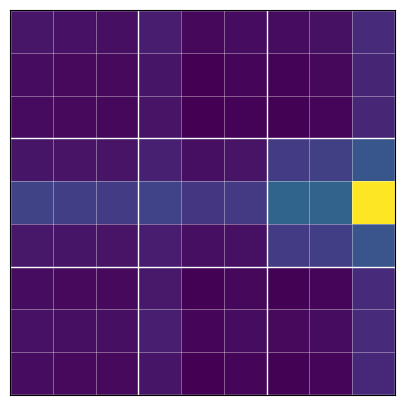

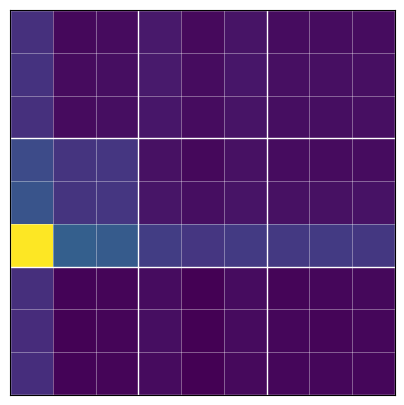

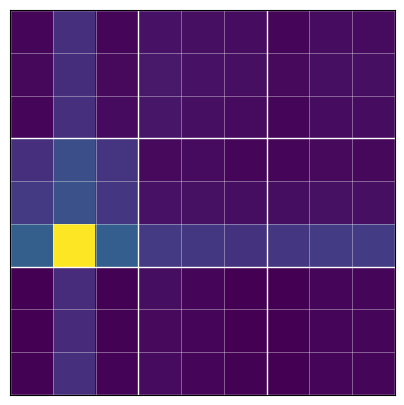

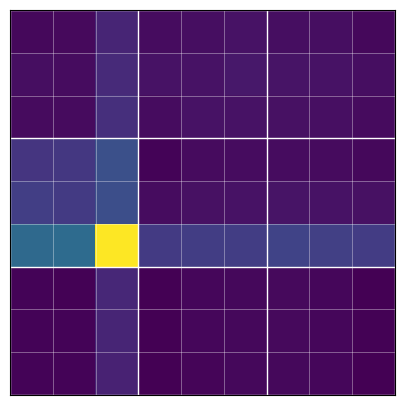

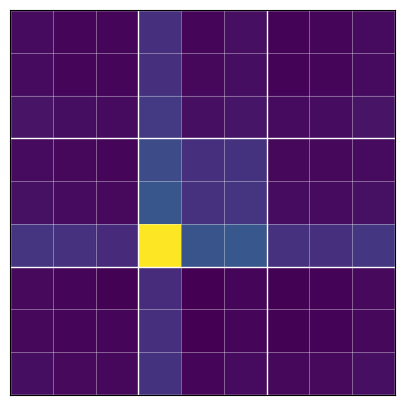

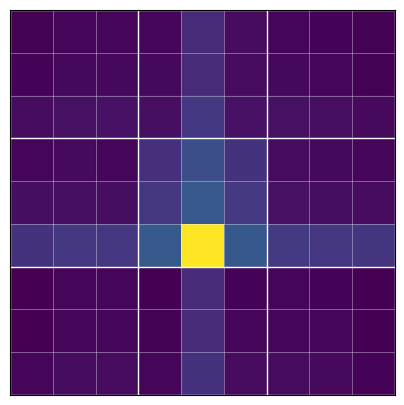

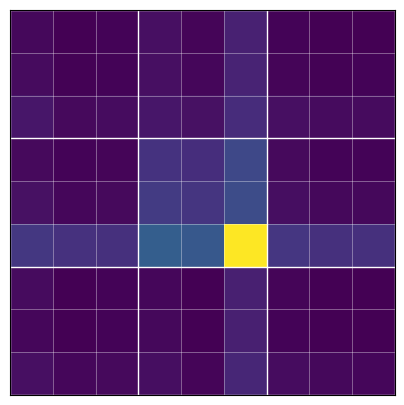

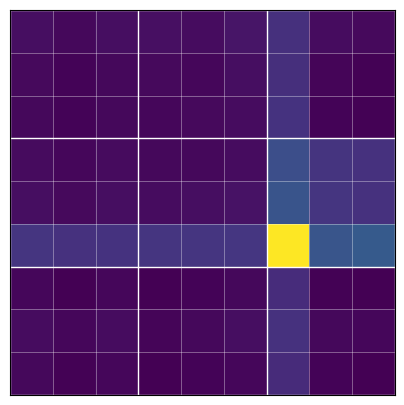

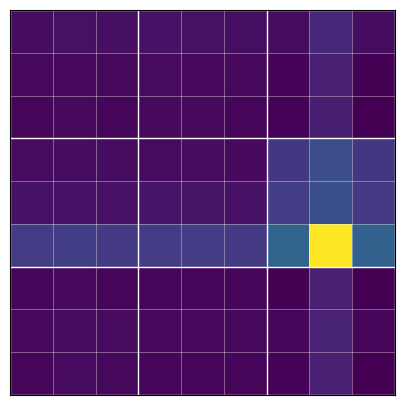

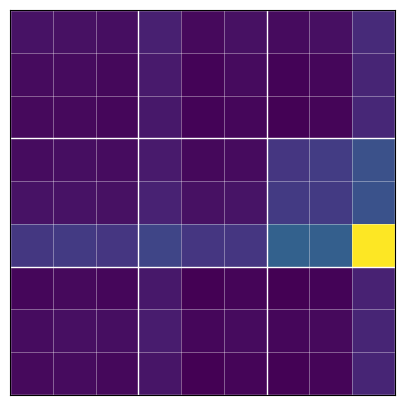

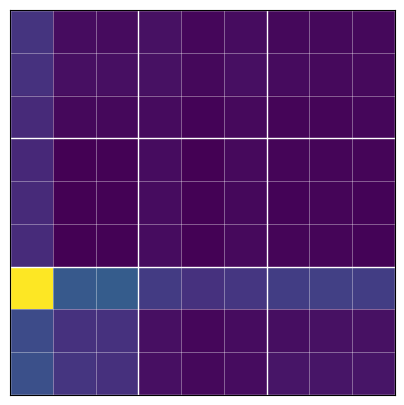

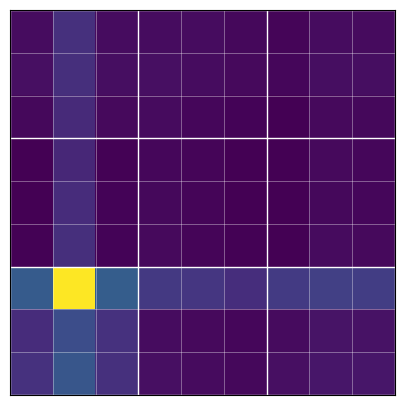

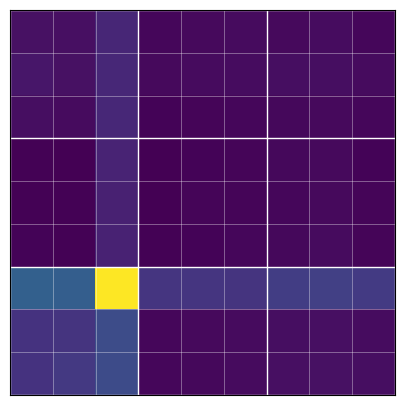

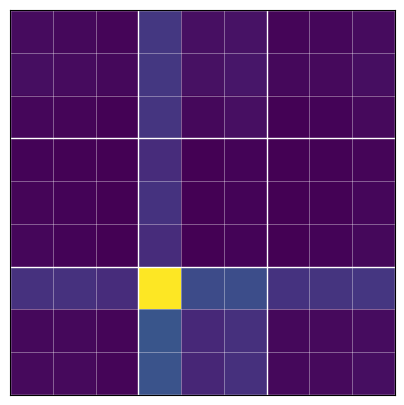

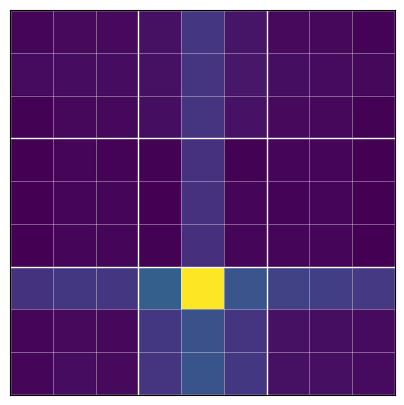

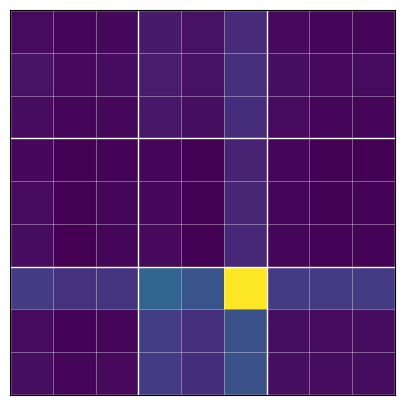

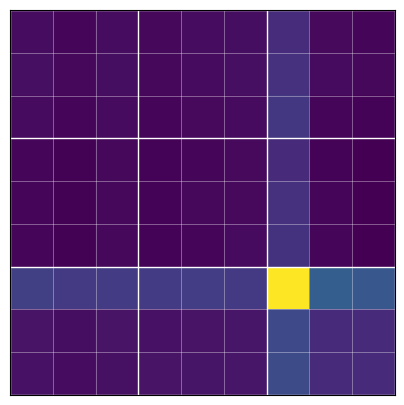

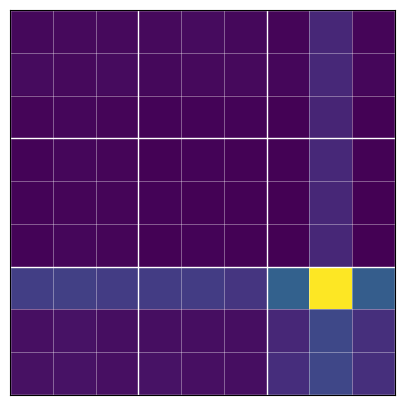

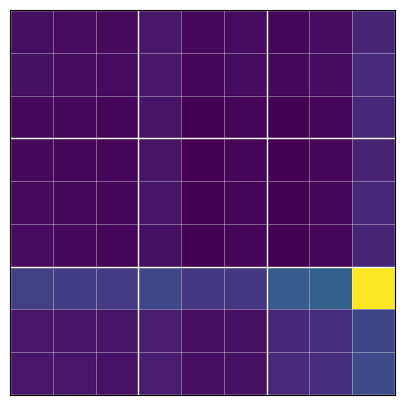

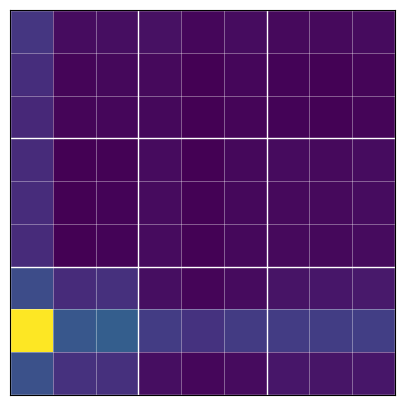

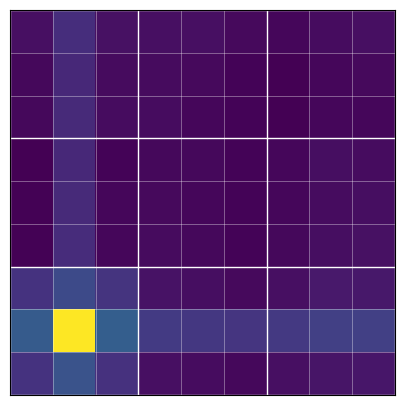

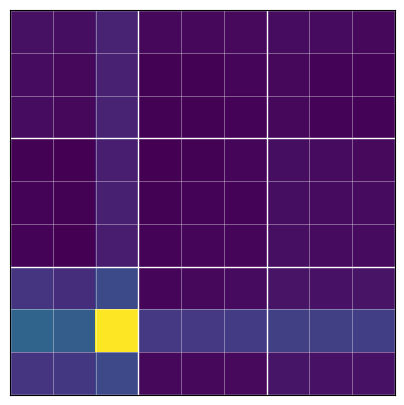

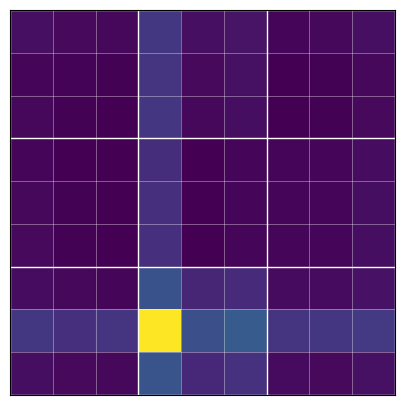

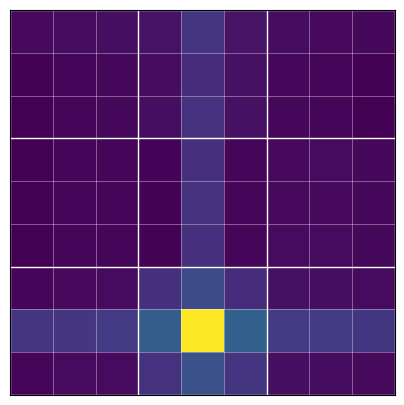

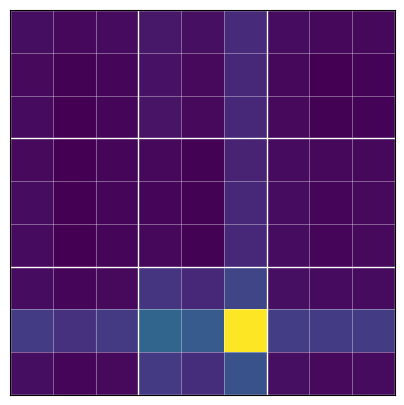

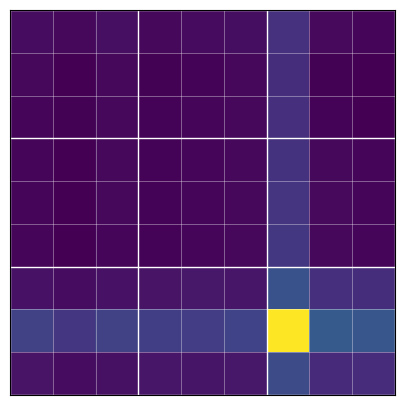

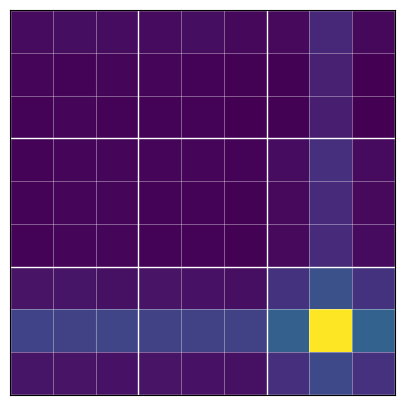

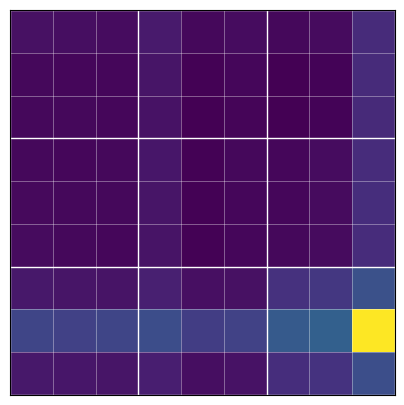

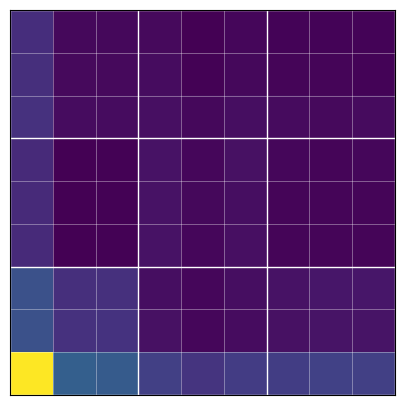

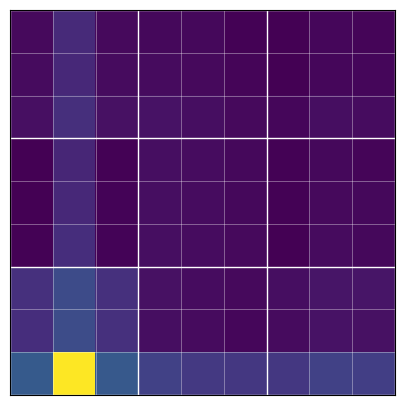

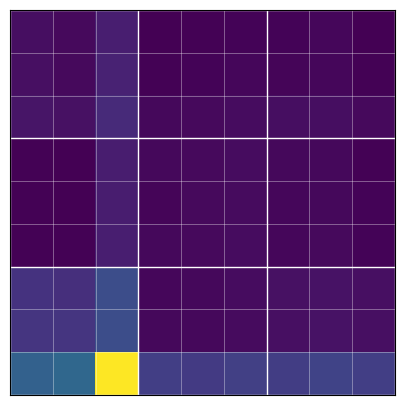

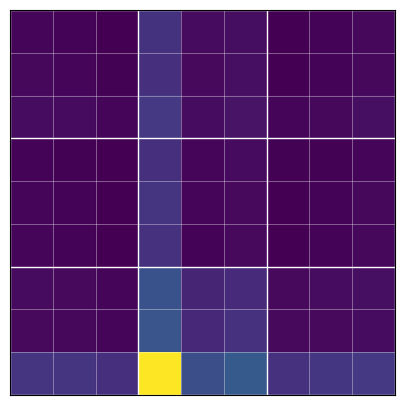

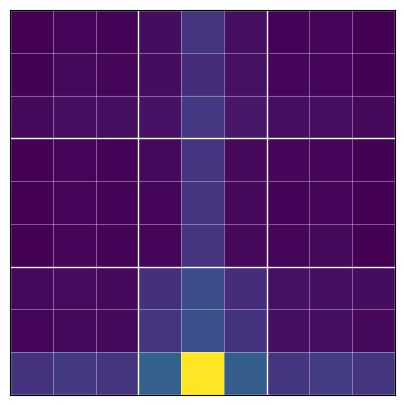

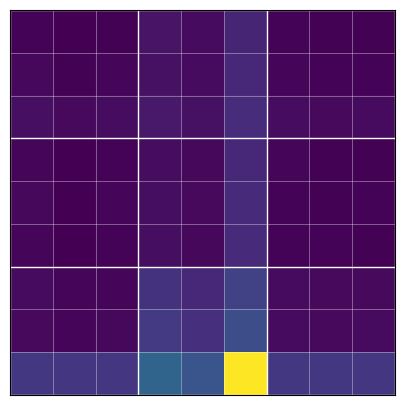

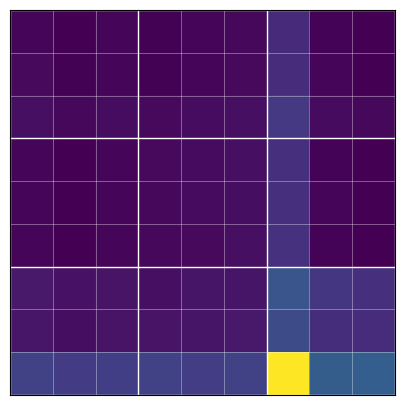

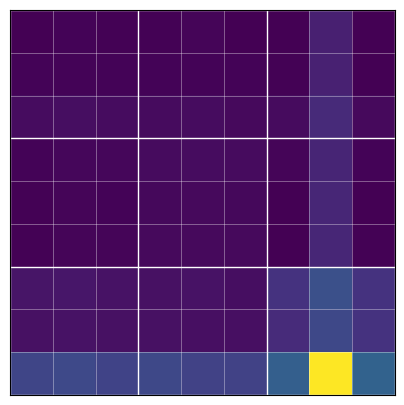

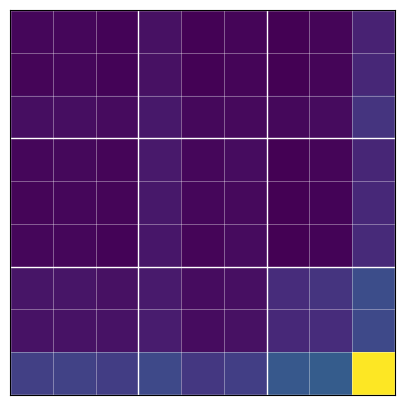

In [36]:
visualize(attn, 'attn_{}'.format(args.module))